In [1]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from transformers import ViTMAEForPreTraining
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from time import time

from engine_hms_model import transform_spectrogram, JobConfig, ModelConfig
from engine_hms_trainer import load_kaggle_data

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(JobConfig.PATHS, JobConfig.ENTROPY_SPLIT)

train_df = pd.concat([train_easy, train_hard], axis=0).reset_index(drop=True)

train_df.head()

eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0   642382           0.0       0.0       0.0        0.0        0.0   
1   751790           0.0       0.0       1.0        0.0        0.0   
2   778705           0.0       0.0       0.0        0.0        0.0   
3  1629671           1.0       0.0       0.0        0.0        0.0   
4  2061593           0.0       0.0       0.0        0.0        0.0   

   other_vote  spectrogram_id     min     max  patient_id   target  
0         1.0        14960202  1008.0  1032.0        5955    Other  
1         0.0       618728447   908.0   908.0       38549      GPD  
2         1.0        52296320     0.0     0.0       40955    Other  
3         0.0      2036345030     0.0   160.0       37481  Seizure  
4         1.0       320962633  1450.0  1450.0       23828    Other

In [3]:
class PreTrainDataset(Dataset):

    def __init__(
        self, 
        df: pd.DataFrame,
        all_specs: Dict[str, np.ndarray],
        all_eegs: Dict[str, np.ndarray],
    ): 
        self.df = df
        self.spectrograms = all_specs
        self.eeg_spectrograms = all_eegs
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        X = self.__data_generation(index)
        X = self.__transform(X)
        return X
    
    def __data_generation(self, index): # --> [(C=8) x (H=128) x (W=256)]
        
        row = self.df.iloc[index]
        r = int((row['min'] + row['max']) // 4)
        
        img_list = []
        for region in range(4):
            img = np.zeros((128, 256), dtype='float32')

            spectrogram = self.spectrograms[row['spectrogram_id']][r:r+300, region*100:(region+1)*100].T
            spectrogram = transform_spectrogram(spectrogram)
            
            img[14:-14, :] = spectrogram[:, 22:-22] / 2.0
            img_list.append(img)

        img = self.eeg_spectrograms[row['eeg_id']]
        img_list += [img[:, :, i] for i in range(4)]
      
        X = np.array(img_list, dtype='float32')
        X = torch.tensor(X, dtype=torch.float32)
        
        return X

    def __transform(self, x):
        # To be implemented...
        return x 

def reshape_input(x): #<- (N, C, H, W)
    x = torch.stack(x, dim=0)
    concat_p1 = torch.cat(torch.chunk(x[:, :4, :, :], 4, dim=1), dim=2)
    concat_p2 = torch.cat(torch.chunk(x[:, 4:, :, :], 4, dim=1), dim=2)
    x_concat = torch.cat((concat_p1, concat_p2), dim=3)
   
    resized = F.interpolate(x_concat, size=(224, 224), mode='bilinear', align_corners=False)
    stacked = resized.repeat(1, 3, 1, 1)
    
    return stacked

In [4]:
def visualize_model(x, model, fig_title=None, save_to=None):

    if len(x.shape) == 3:
        x = x.unsqueeze(0)

    output = model(x)
    loss = output.loss
    y = output.logits
    mask = output.mask

    print("LOSS:", loss.item())

    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)
    x = x.detach().cpu()

    # masked image
    im_masked = x * (1 - mask)
    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    fig, axes = plt.subplots(x.shape[0], 3, figsize=(15, 5*x.shape[0]))
    for i in range(x.shape[0]):
        if x.shape[0] == 1:
            axes[0].imshow(x[i, :, :, 0].squeeze(), cmap='plasma', vmin=-1, vmax=2)
            axes[1].imshow(im_paste[i, :, :, 0].squeeze(), cmap='plasma', vmin=-1, vmax=2)
            axes[2].imshow(im_masked[i, :, :, 0].squeeze(), cmap='plasma', vmin=-1, vmax=2)
        else:
            axes[i, 0].imshow(x[i, :, :, 0].squeeze(), cmap='plasma', vmin=-1, vmax=2)
            axes[i, 1].imshow(im_paste[i, :, :, 0].squeeze(), cmap='plasma', vmin=-1, vmax=2)
            axes[i, 2].imshow(im_masked[i, :, :, 0].squeeze(), cmap='plasma', vmin=-1, vmax=2)

    if x.shape[0] == 1:
        axes[0].set_title('Original')
        axes[1].set_title(f'{fig_title}\nRecon.')
        axes[2].set_title('Masked')
    else:
        axes[0, 0].set_title('Original')
        axes[0, 1].set_title(f'{fig_title}\nRecon.')
        axes[0, 2].set_title('Masked')

    for ax in axes.flatten():
        ax.axis('off')
    fig.tight_layout()

    if save_to:
        plt.savefig(save_to)

    plt.show()

In [5]:
def train_mae(model, train_loader, config):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=config['WEIGHT_DECAY'])
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-4,
        epochs=config['EPOCHS'],
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    model.to(DEVICE)
    best_loss = np.inf
    early_stopping_counter = 0

    loss_records = {}
    for epoch in range(config['EPOCHS']):
        start_time = time()
        model.train()
        losses = []
        
        with tqdm(train_loader, unit="batch", desc='Train') as pbar:
            for step, X in enumerate(pbar):
                X = X.to(DEVICE)
                optimizer.zero_grad()
                output = model(X)
                loss = output.loss
                loss.backward()

                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), config['MAX_GRAD_NORM'])
                optimizer.step()
                scheduler.step()

                losses.append(loss.item())

                if step % config['PRINT_FREQ'] == 0 or step == len(train_loader) - 1:
                    lr = scheduler.get_last_lr()[0]
                    info = f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}]"
                    info += f" | Loss: {loss:.4f} | Grad: {grad_norm:.4f} | LR: {lr:.4e}"
                    pbar.set_postfix_str(info)
        
        epoch_loss = np.mean(losses)
        print(f"{'-'*100}\nEpoch {epoch + 1} - Avg Loss: {epoch_loss:.4f} - Time: {time() - start_time:.2f}s \n{'-'*100}")
                
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, f"{config['OUTPUT_DIR']}/{config['MODEL_NAME']}_Best.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= config['EARLY_STOPPING_PATIENCE']:
                print(f"Early stopping triggered. Stopping training after {epoch + 1} epochs.")
                break

        loss_records[f"Epoch_{epoch}"] = losses
                
    return best_model_weights, loss_records


In [6]:
pretrain_dataset = PreTrainDataset(train_df, all_specs, all_eegs)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=16, shuffle=False, collate_fn=reshape_input)

In [7]:
mae_config = ViTMAEForPreTraining.config_class.from_pretrained('facebook/vit-mae-base')
mae_config.attention_probs_dropout_prob = 0.05
mae_config.hidden_dropout_prob = 0.05

raw_mae_model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base', config=mae_config)

LOSS: 0.03625241294503212


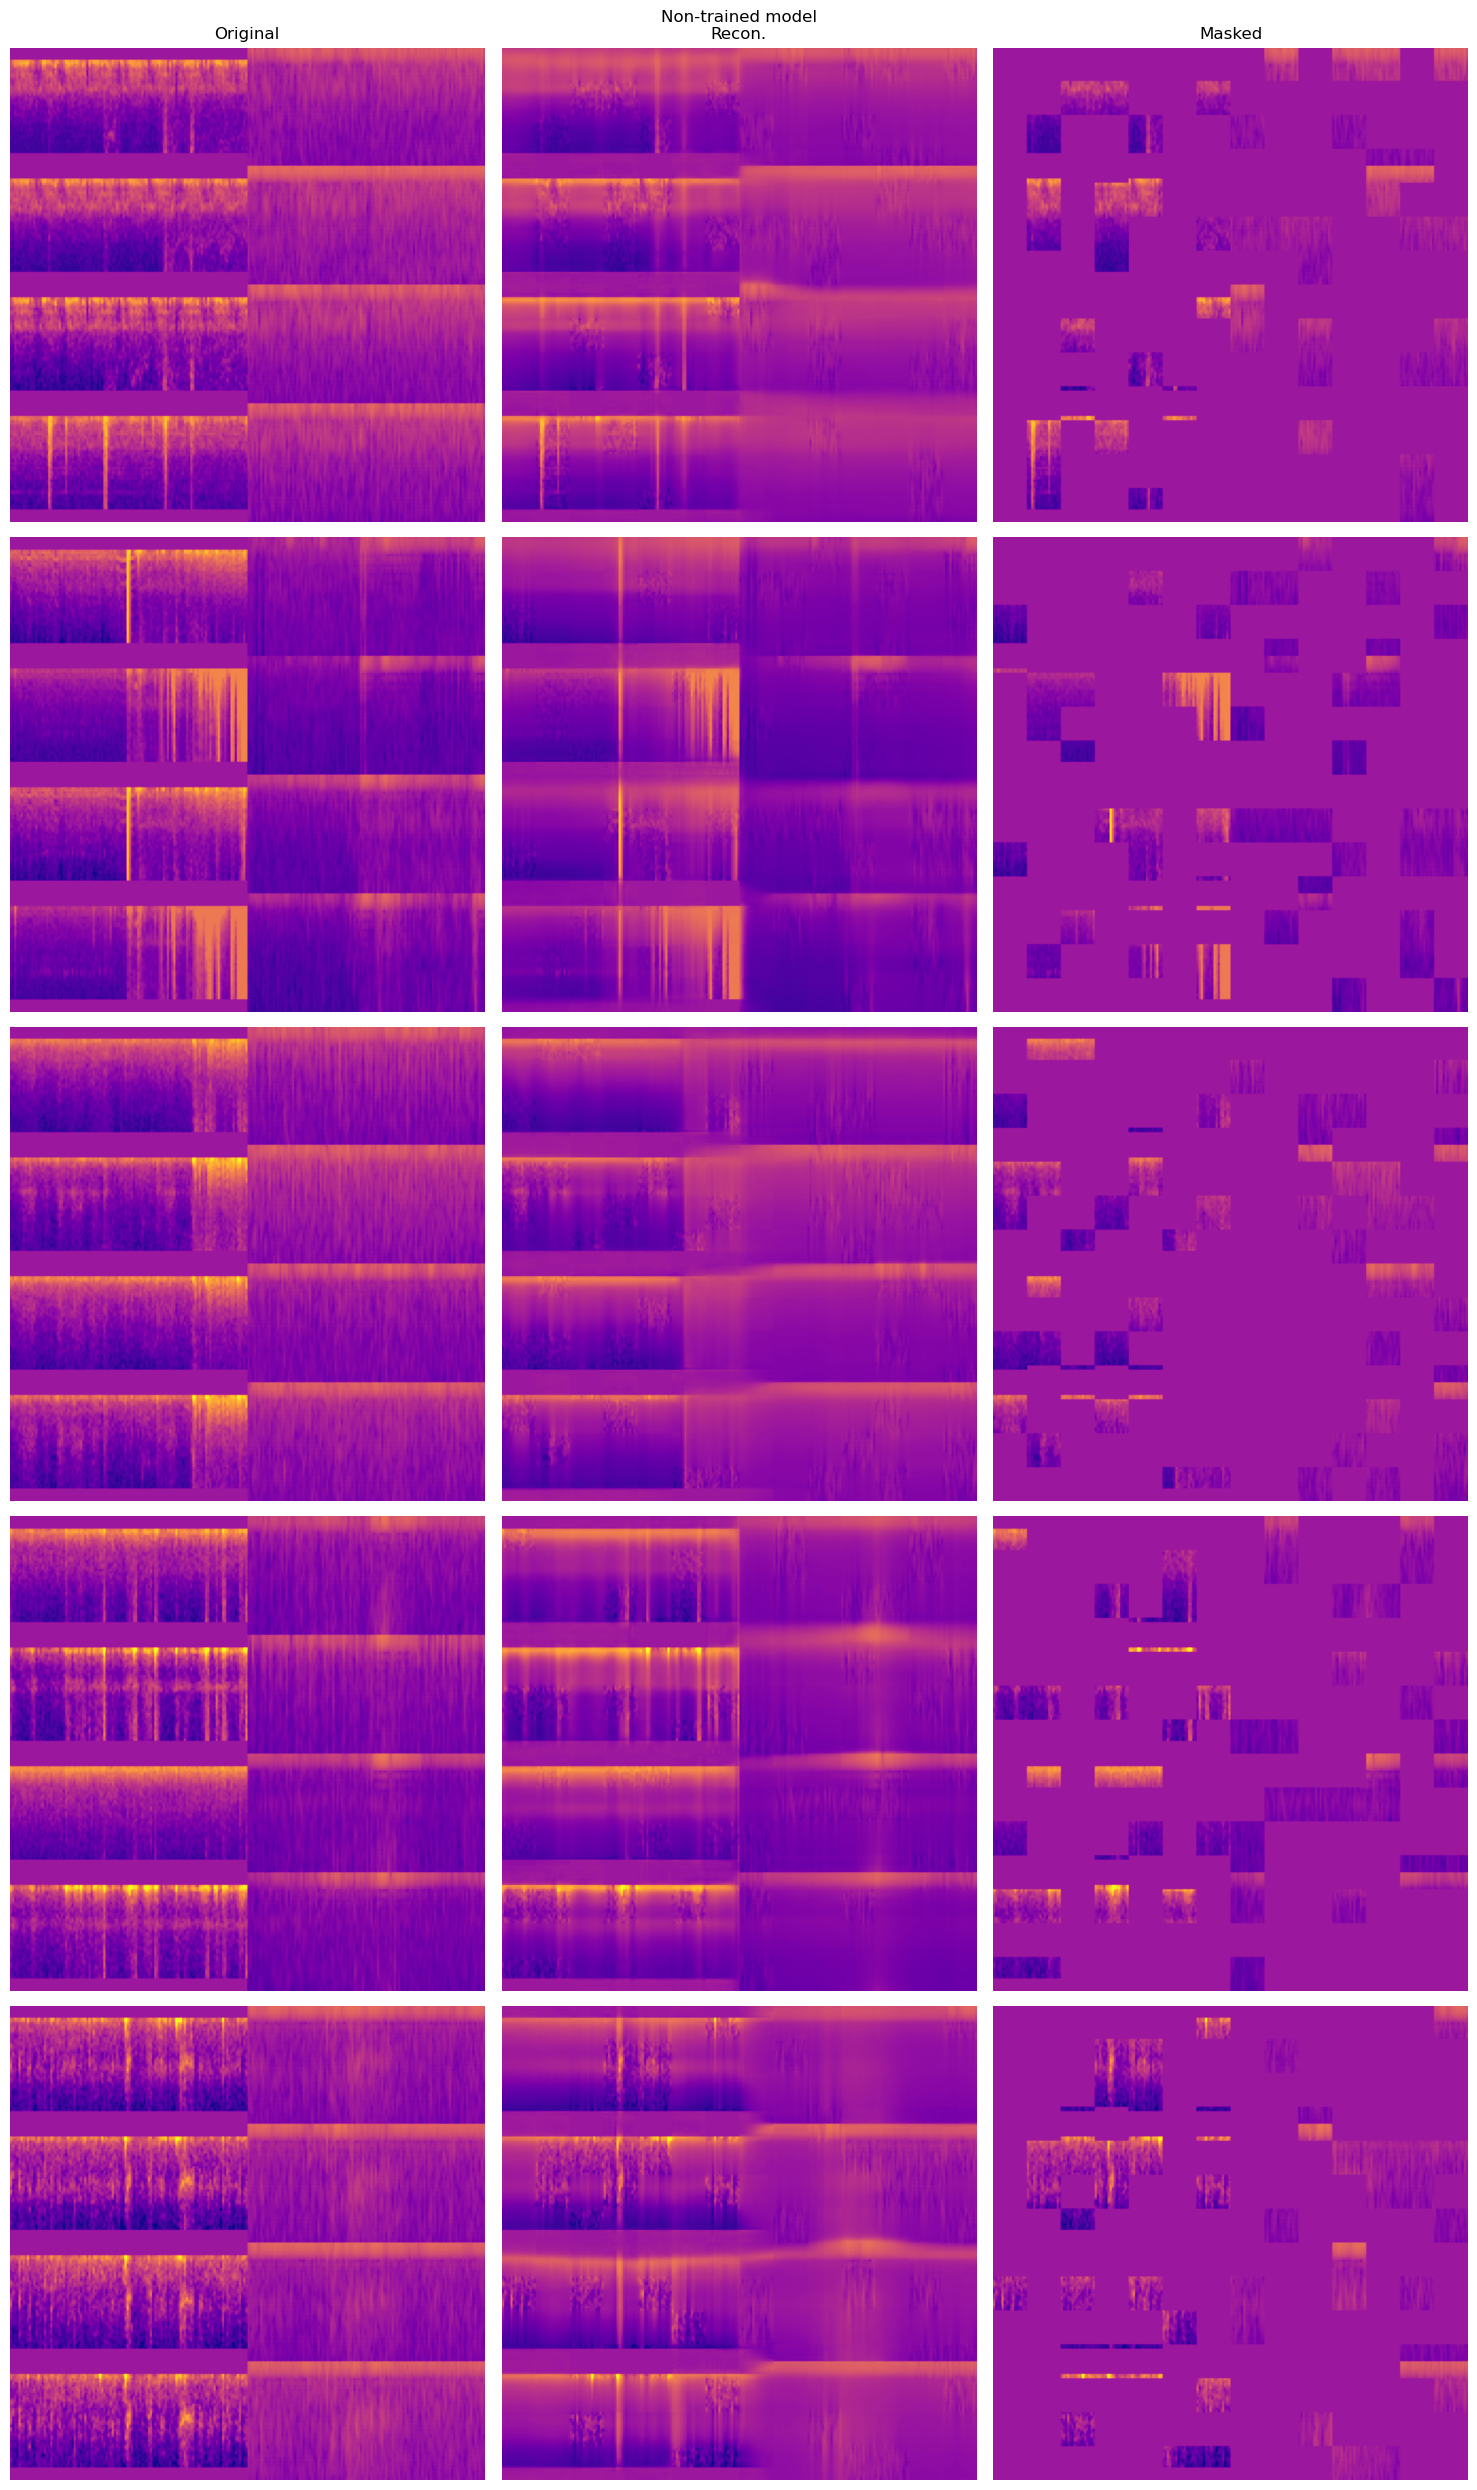

In [8]:
visual_idx = [0, 100, 1024, 2478, 13257]
X = reshape_input([ pretrain_dataset[idx] for idx in visual_idx ])
visualize_model(X, raw_mae_model, fig_title='Non-trained model', save_to="./outputs/vit_mae_pretraining/raw_mae.png")

In [ ]:
config = {
    'OUTPUT_DIR': './outputs/vit_mae_pretraining',
    'MODEL_NAME': 'ViTMAE_PreTrained',
    'WEIGHT_DECAY': 0.01,
    'EPOCHS': 5,
    'MAX_GRAD_NORM': 1e7,
    'PRINT_FREQ': 50,
    'EARLY_STOPPING_PATIENCE': 2
}

model_weights, loss_records = train_mae(raw_mae_model, pretrain_loader, config)

LOSS: 0.013785510323941708


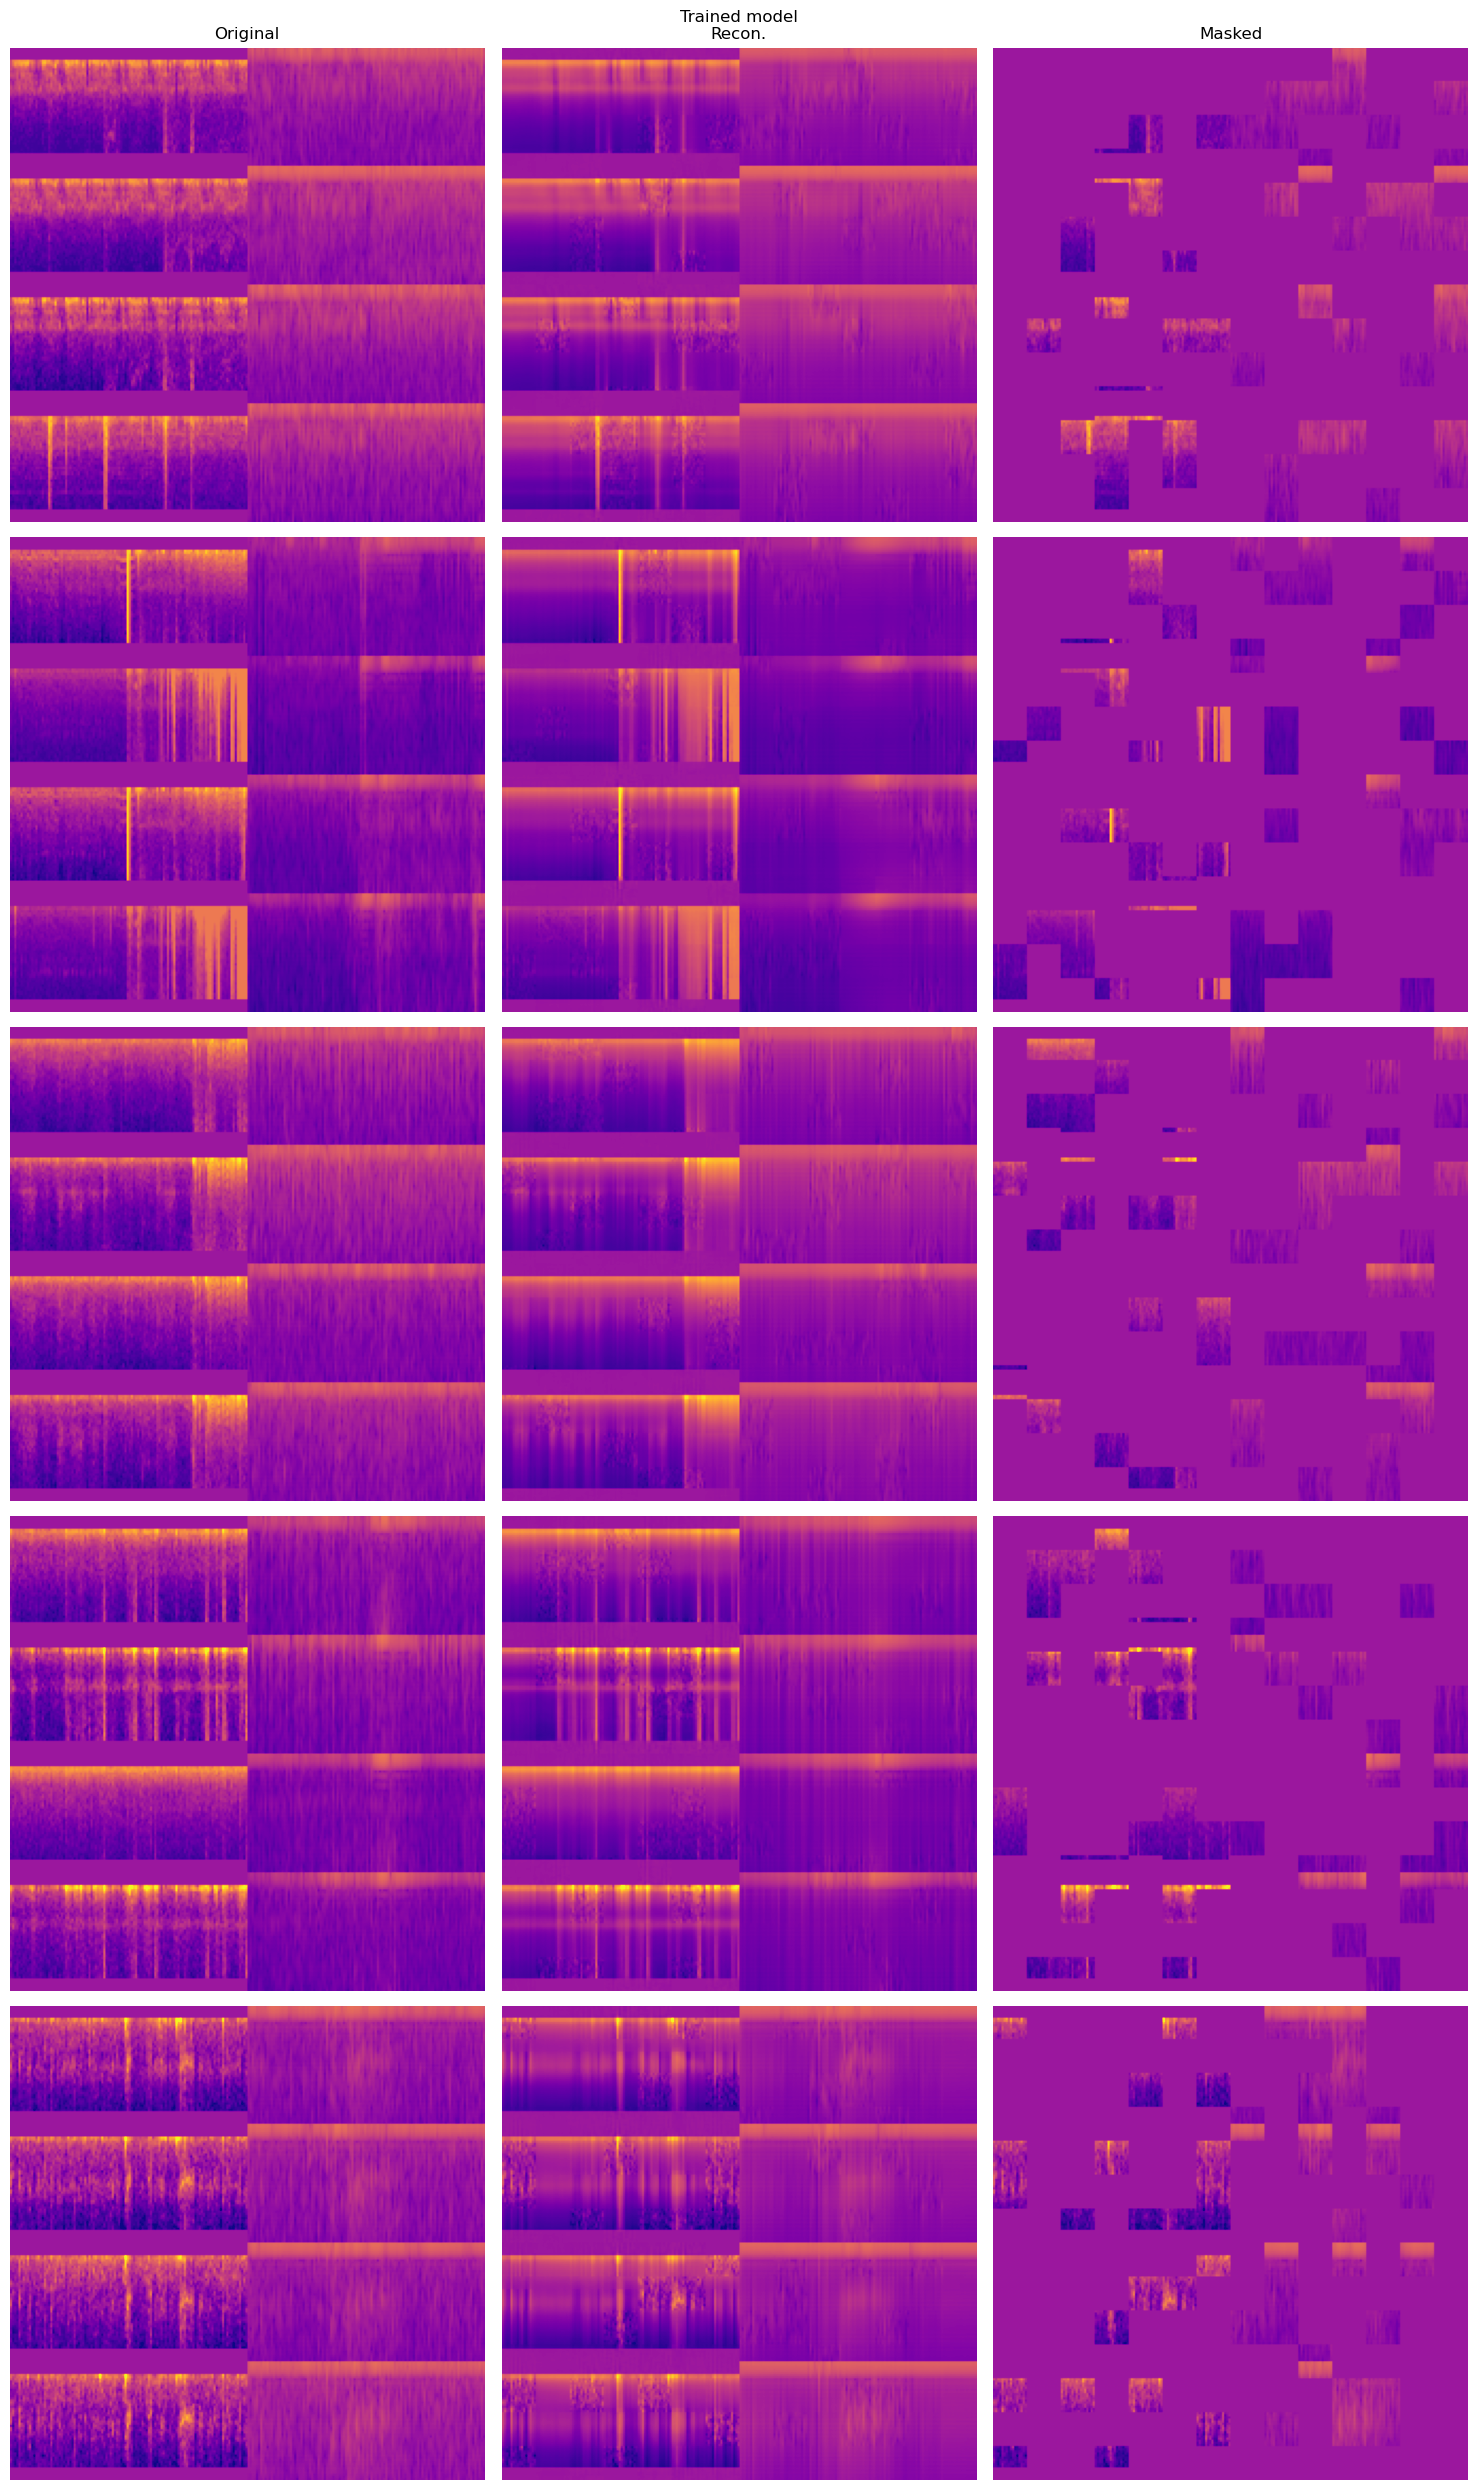

In [17]:
trained_model = ViTMAEForPreTraining.from_pretrained(f"{config['OUTPUT_DIR']}/{config['MODEL_NAME']}_Best.pth", config=mae_config)
X = reshape_input([ pretrain_dataset[idx] for idx in visual_idx ])
visualize_model(X, trained_model, fig_title='Trained model', save_to="./outputs/vit_mae_pretraining/trained_mae.png")

In [1]:
df_loss = pd.DataFrame(loss_records)
df_loss.to_csv(f"{config['OUTPUT_DIR']}/pretrain_loss_records.csv")

# plot the loss with smoothing
fig, ax = plt.subplots(figsize=(10, 5))
df_loss.rolling(window=50).mean().plot(
    title='Training Loss', 
    xlabel='Steps', 
    ylabel='Loss', 
    ax=ax, 
    figsize=(10, 5)
    )

ax.grid(True)
plt.show()

print("Training Loss Records: ")
print(df_loss.mean())

NameError: name 'pd' is not defined